## 2) Análisis de sentimiento en Opiniones de Películas

En esta sección se busca extraer información acerca de la actitud de una persona, mediante evaluaciones escritas de películas, donde la opinión puede ser positiva, negativa o neutral. La dificultad radica en que el lenguaje usado es muy ambiguo en informal, como las personas naturalmente se expresan, por lo que negaciones, sarcasmo y abreviaciones deben ser tratadas con cuidado.

Los datos fueron publicados en Kaggle, y cada registro corresponde a una opinión sobre una película en la forma de un texto. Las clases son positiva y negativa, o 1 y 0, no se considera una clase neutra. Los vectores de características a usar son la frecuencia de cada palabra del vocabulario en una opinión. 

### a) Dataframe y exploración

Se descarga el dataset, se construye el DataFrame, para luego explorar los datos.

In [13]:
import urllib.request as urllib
import pandas as pd

train_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train"
test_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev"
train_data_f = urllib.urlretrieve(train_data_url, "train_data.csv")
test_data_f = urllib.urlretrieve(test_data_url, "test_data.csv")
ftr = open("train_data.csv", "r", encoding="latin-1")
fts = open("test_data.csv", "r", encoding="latin-1")
rows = [line.split(" ",1) for line in ftr.readlines()]
train_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
train_df['Sentiment'] = pd.to_numeric(train_df['Sentiment'])
rows = [line.split(" ",1) for line in fts.readlines()]
test_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
test_df['Sentiment'] = pd.to_numeric(test_df['Sentiment'])

In [33]:
import matplotlib.pyplot as plt

print("Reviews positivas conjunto de entrenamiento: " + str(len(train_df.values[train_df.values == 1])))
print("Reviews negativas conjunto de entrenamiento: " + str(len(train_df.values[train_df.values == -1])))
train_df.head()

Reviews positivas conjunto de entrenamiento: 1770
Reviews negativas conjunto de entrenamiento: 1784


,Sentiment,Text
0,-1,"everything's serious , poetic , earnest and --..."
1,-1,"narratively , trouble every day is a plodding ..."
2,1,a truly wonderful tale combined with stunning ...
3,1,jason patric and ray liotta make for one splen...
4,-1,haneke keeps us at arm's length . guided more ...


In [32]:
print("Reviews positivas conjunto de pruebas: " + str(len(test_df.values[test_df.values == 1])))
print("Reviews negativas conjunto de pruebas: " + str(len(test_df.values[test_df.values == -1])))
test_df.head()

Reviews positivas conjunto de pruebas: 1751
Reviews negativas conjunto de pruebas: 1803


,Sentiment,Text
0,-1,screenwriter dan schneider and director shawn ...
1,-1,"home alone goes hollywood , a funny premise un..."
2,1,seldom has a movie so closely matched the spir...
3,-1,"less dizzying than just dizzy , the jaunt is p..."
4,-1,an ultra-low-budget indie debut that smacks mo...


Se pueden considerar las clases como balanceadas en ámbos conjuntos, por lo que no es necesario realizar un remuestreo. También se observa que el largo de los reviews varía, algunos poseen signos de puntuación y/o palabras en un idioma distinto al inglés.

A continuación se importa y descarga la librería de procesamiento de lenguaje natural que se utilizará en esta sección. 

In [34]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### b) Preprocesamiento

En esta parte, se realiza el preprocesamiento necesario para mejorar en lo posible el desempeño de los clasificadores. El paso que todos los extractores de palabras que se definen comparten es transformar todo el texto a minúscula. Luego, según el extractor y los parámetros, se eliminan las *stop words* de los reviews, y se hace stemming o lematización.

Stemming y lematización son similares, en el sentido de que ámbos buscan llevar las palabras a sus raíces morfológicas, o alguna otra forma común. La diferencia es que stemming es una heurística cruda que simplemente trunca las palabras, esperando obtener el resultado correcto. Lematización usa un vocabulario y análisis morfolófico para encontrar la forma de diccionario de las palabras, o *lemma*.

A continuación se implementa el extractor de palabras con stemming y sin stemming (solo minúscula), usando la librería ntlk.

In [90]:
import re, time
from nltk.book import *
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer

# lower case + stemming
def word_extractor(text, stop_words=True):
    ps = PorterStemmer()
    text = re.sub(r'([a-z])\1+', r'\1\1',text)
    words = ""
    wordtokens = [ ps.stem(word.lower()) \
                for word in word_tokenize(text) ]
    if(stop_words):
        commonwords = stopwords.words('english')
        commonwords.remove("not")
        for word in wordtokens:
            if word not in commonwords:
                    words+=" "+word
    else:
        for word in wordtokens:
            words+=" "+word
    return words

# only lower case
def word_extractorbis(text):
    ps = PorterStemmer()
    commonwords = stopwords.words('english')
    commonwords.remove("not")
    text = re.sub(r'([a-z])\1+', r'\1\1',text)
    words = ""
    wordtokens = [ word.lower() \
                for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords:
                words+=" "+word
    return words

Algunos ejemplos de cómo funciona cada extractor a continuación.

In [80]:
print("* Examples with lower case only\n")
print(word_extractorbis("I (LOve) to? eat cake"))
print(word_extractorbis("I love eating cake"))
print(word_extractorbis("I loved eating the cake"))
print(word_extractorbis("I do not love eating cake"))

print("\n* Examples with lower case + stemming\n")
print(word_extractor("I (LOve) to?, eat cake ?"))
print(word_extractor("I love eating cake"))
print(word_extractor("I loved eating the cake"))
print(word_extractor("I do not love eating cake"))

text_1 = "Many people quickly became stunned when they saw the black-clothed young man suddenly appear on the wall. A moment later, a wild joy abruptly surged. Many different forms of addresses suddenly reverberated over the fortress. Although the young man appeared to have matured after a couple of years, his extremely familiar face was still recognized by many people in an instant."
print("\n* Text with lower case only\n")
print(word_extractorbis(text_1))

print("\n* Text with lower case + stemming\n")
print(word_extractor(text_1))

* Examples with lower case only

 ( love ) ? eat cake
 love eating cake
 loved eating cake
 not love eating cake

* Examples with lower case + stemming

 ( love ) ? , eat cake ?
 love eat cake
 love eat cake
 not love eat cake

* Text with lower case only

 many people quickly became stunned saw black-clothed young man suddenly appear wall . moment later , wild joy abruptly surged . many different forms addresses suddenly reverberated fortress . although young man appeared matured couple years , extremely familiar face still recognized many people instant .

* Text with lower case + stemming

 mani peopl quickli becam stun saw black-cloth young man suddenli appear wall . moment later , wild joy abruptli surg . mani differ form address suddenli reverber fortress . although young man appear matur coupl year , hi extrem familiar face wa still recogn mani peopl instant .


Se observa que efectivamente stemming trunca algunas palabras (lleva los verbos a su infinitivo), como "eating" a "eat". En el caso del texto, se observan algunos problemas, como "many" a "mani", y en general, todas las palabras terminadas en "y". 

### c) Lemmatizer

Ahora se implementa el mismo extractor, pero usando el Lemmatizer de la librería nltk. Luego se comparan los mismos ejemplos de la pregunta anterior. El argumento *stop words* indica si se deben eliminar las stopwords de los vectores o no.

In [89]:
def word_extractor2(text, stop_words=True):
    wordlemmatizer = WordNetLemmatizer()
    text = re.sub(r'([a-z])\1+', r'\1\1',text)
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower()) \
                  for word in word_tokenize(text)]
    if(stop_words):
        commonwords = stopwords.words('english')
        commonwords.remove("not")
        for word in wordtokens:
            if word not in commonwords:
                words+=" "+word
    else:
        for word in wordtokens:
            words+=" "+word
    return words 

In [88]:
print("* Examples with lower case only\n")
print(word_extractorbis("I (LOve) to? eat cake"))
print(word_extractorbis("I love eating cake"))
print(word_extractorbis("I loved eating the cake"))
print(word_extractorbis("I do not love eating cake"))

print("\n* Examples with lower case + stemming\n")
print(word_extractor("I (LOve) to?, eat cake ?"))
print(word_extractor("I love eating cake"))
print(word_extractor("I loved eating the cake"))
print(word_extractor("I do not love eating cake"))

print("\n* Examples with lower case + lemmatization\n")
print(word_extractor2("I (LOve) to?, eat cake ?"))
print(word_extractor2("I love eating cake"))
print(word_extractor2("I loved eating the cake"))
print(word_extractor2("I do not love eating cake"))

print("\n* Text with lower case only\n")
print(word_extractorbis(text_1))

print("\n* Text with lower case + stemming\n")
print(word_extractor(text_1))

print("\n* Text with lower case + lemmatization\n")
print(word_extractor2(text_1))

* Examples with lower case only

 ( love ) ? eat cake
 love eating cake
 loved eating cake
 not love eating cake

* Examples with lower case + stemming

 ( love ) ? , eat cake ?
 love eat cake
 love eat cake
 not love eat cake

* Examples with lower case + lemmatization

 ( love ) ? , eat cake ?
 love eating cake
 loved eating cake
 not love eating cake

* Text with lower case only

 many people quickly became stunned saw black-clothed young man suddenly appear wall . moment later , wild joy abruptly surged . many different forms addresses suddenly reverberated fortress . although young man appeared matured couple years , extremely familiar face still recognized many people instant .

* Text with lower case + stemming

 mani peopl quickli becam stun saw black-cloth young man suddenli appear wall . moment later , wild joy abruptli surg . mani differ form address suddenli reverber fortress . although young man appear matur coupl year , hi extrem familiar face wa still recogn mani peopl i

Se puede observar que el lematizador es mucho más sutil en su operación, elimiando plurales, pero manteniendo algunas conjugaciones de verbos. En general, el texto de salida del lematizador es más legible que el de stemming. Es importante notar que los signos de puntuación no son eliminados completamente de los vectores, y que cuando se eliminan las stopwords, no se considera la palabra "not", ya que puede cambiar completamente el sentido de una frase, y por lo tanto vale la pena mantenerla dentro de los reviews.

### d) Count Vectorizer

Con los extractores de palabras implementados, debemos encontrar una representación de los reviews para usarlos en los clasificadores. En esta sección, se utilizan vectores de frecuencia de tokens (palabras), que se implementa con CountVectorizer de la librería sklearn. El primer caso es para el extractor con lematización y minúsculas.

#### Lematización + eliminación de stopwords

In [56]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

texts_train = [word_extractor2(text) for text in train_df.Text]
texts_test = [word_extractor2(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))

Vocabulary size:  9667


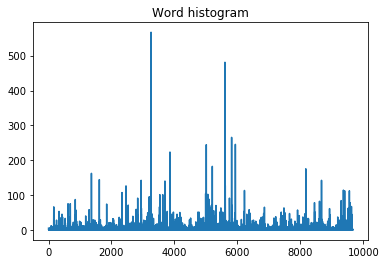

In [64]:
print("Vocabulary size: ", len(vocab))
plt.plot(np.arange(1,len(vocab)+1), dist)
plt.title("Word histogram")
plt.show()

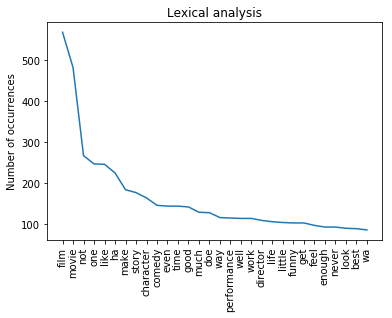

In [67]:
i=0
tabtag = []
x = np.arange(30)
distsorted = sorted(dist, reverse=True) 
distsortedindex = sorted(range(len(dist)), key=lambda k: dist[k],reverse=True)
for count in distsortedindex:
    tabtag.append(vocab[count]) 
    i = i+1

y = distsorted[:30]
my_xticks = tabtag
plt.xticks(x, my_xticks,  rotation='vertical')
plt.ylabel('Number of occurrences')
plt.title('Lexical analysis')
plt.plot(x, y)
plt.show()

El vocabulario es de 9667 palabras cuando se usa el extractor con lematización, y las palabras más frecuentes se encuentran en el gráfico anterior. Efectivamente, la palabra "not" aparece en tercer lugar, por lo que no considerarla como stopword tendrá un efecto significativo.

### e) Model Score

La siguiente función nos permite medir el desempeño de un modelo genérico, entregando la precisión en conjuntos de entrenamiento y pruebas, y además el *classification report* de sklearn, que consiste de la precisión, recall, f1 score y soporte.

La precisión corresponde a $PPV = TP / ( TP + FP)$, y describe el desempeño del clasificador en términos de la clase positiva. El recall se calcula como $TPR = TP / ( TP + FN)$, también llamado sensitividad, y mide la habilidad del clasificador para identificar la clase positiva. El $F_1$ score es la media harmónica de la precisión y el recall, y mide precisión (*accuracy*, distinto de la precisión PPV). El soporte corresponde a la cantidad de ocurrencias por cada clase.

In [68]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

def score_the_model(model,x,y,xt,yt,text):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print("Training Accuracy %s: %f"%(text,acc_tr))
    print("Test Accuracy %s: %f"%(text,acc_test))
    print("Detailed Analysis Testing Results ...")
    print(classification_report(yt, model.predict(xt), target_names=['+','-']))

In [78]:
model = LinearSVC().fit(features_train, labels_train)
target_names = ['class 0', 'class 1']
score_the_model(model,features_train, labels_train, features_test, labels_test,"Linear SVC")

Training Accuracy Linear SVC: 1.000000
Test Accuracy Linear SVC: 0.715170
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.71      0.72      1803
          -       0.71      0.72      0.71      1751

avg / total       0.72      0.72      0.72      3554



Con este ejemplo se puede observar el reporte de clasificación que se utilizará para medir el desempeño en las preguntas que siguen. Se muestran los estadísticos para cada clase, como el promedio o total. 

### f) Naive Bayes

Usando la función anterior para medir el desempeño, se construye un clasificador Naive Bayes con la librería sklearn, el cual se entrenará con distintos conjuntos de entrenamiento, variando los extractores de palabras y la eliminación de stopwords. 

#### Naive Bayes - Lematización + eliminación de stopwords

In [77]:
from sklearn.naive_bayes import BernoulliNB
import random

def do_NAIVE_BAYES(x,y,xt,yt):
    model = BernoulliNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"BernoulliNB")
    return model
model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)
test_pred = model.predict_proba(features_test)
spl = random.sample(range(len(test_pred)), 15)
for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print(sentiment, text)

Training Accuracy BernoulliNB: 0.958920
Test Accuracy BernoulliNB: 0.737968
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.72      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554

[ 0.85114114  0.14885886] it's lost the politics and the social observation and become just another situation romance about a couple of saps stuck in an inarticulate screenplay .

[ 0.98914483  0.01085517] girlfriends are bad , wives are worse and babies are the kiss of death in this bitter italian comedy .

[ 0.945893  0.054107] in the era of the sopranos , it feels painfully redundant and inauthentic .

[ 0.93739969  0.06260031] don't expect any subtlety from this latest entry in the increasingly threadbare gross-out comedy cycle .

[ 0.14281489  0.85718511] the far future may be awesome to consider , but from period detail to matters of the heart , this film i

La precisión de clasificación para Naive Bayes usando lematización y eliminación de stopwords es cercana al $0.74$. Se pueden observar algunos reviews donde el clasificador no está muy seguro de su predicción (valores cercanos a $0.5$). Notamos que aquellos reviews que no dan una opinión en sí, sino que son un resumen o sinopsis de la película, son particularmente difíciles de predecir, como en los reviews 2 y 10 de la muestra aleatoria.

#### Naive Bayes - Solo Lematización 

In [91]:
texts_train = [word_extractor2(text, stop_words=False) for text in train_df.Text]
texts_test = [word_extractor2(text, stop_words=False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))

Vocabulary size:  9729


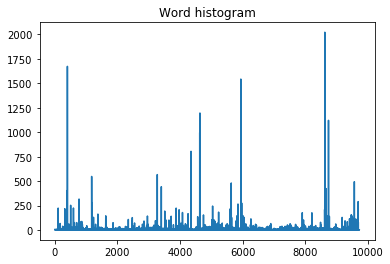

In [92]:
print("Vocabulary size: ", len(vocab))
plt.plot(np.arange(1,len(vocab)+1), dist)
plt.title("Word histogram")
plt.show()

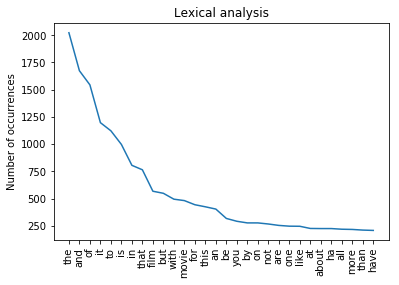

In [93]:
i=0
tabtag = []
x = np.arange(30)
distsorted = sorted(dist, reverse=True) 
distsortedindex = sorted(range(len(dist)), key=lambda k: dist[k],reverse=True)
for count in distsortedindex:
    tabtag.append(vocab[count]) 
    i = i+1

y = distsorted[:30]
my_xticks = tabtag
plt.xticks(x, my_xticks,  rotation='vertical')
plt.ylabel('Number of occurrences')
plt.title('Lexical analysis')
plt.plot(x, y)
plt.show()

Sin eliminar las stopwords, el vocabulario aumenta (aunque no considerablemente) y las palabras más frecuentes pasan a ser los conectores. "film" baja desde el primer lugar hasta el noveno, sobrepasada por las stopwords. A continuación veremos como es el desempeño de Naive Bayes para esta conjunto.

In [94]:
model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)
test_pred = model.predict_proba(features_test)
spl = random.sample(range(len(test_pred)), 15)
for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print(sentiment, text)

Training Accuracy BernoulliNB: 0.955262
Test Accuracy BernoulliNB: 0.748945
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.74      0.75      1803
          -       0.74      0.76      0.75      1751

avg / total       0.75      0.75      0.75      3554

[ 0.98882421  0.01117579] this version of h . g . wells' time machine was directed by h . g . wells' great-grandson . they should have found orson welles' great-grandson .

[ 0.93511252  0.06488748] just one more collection of penis , breast and flatulence gags in search of a story . or a profit . or some damn thing .

[ 0.99869444  0.00130556] ultimately the , yes , snail-like pacing and lack of thematic resonance make the film more silly than scary , like some sort of martha stewart decorating program run amok .

[ 0.22697714  0.77302286] a stylish thriller .

[ 0.05828467  0.94171533] matches neorealism's impact by showing the humanity of a war-torn land fille

La precisión subió un punto porcentual aproximadamente al incluir las stopwords, aunque es necesario una validación estadística para estar realmente seguros. Si es el caso, entonces la información que contienen las stopwords es necesaria para la clasificación correcta de los reviews, aunque puede que solo sean algunas palabras claves. Para encontrar el subconjunto de palabras claves óptimo para el problema, se debe realizar validación cruzada u otro similar.



#### Naive Bayes - Solo Stemming

In [95]:
texts_train = [word_extractor(text, stop_words=False) for text in train_df.Text]
texts_test = [word_extractor(text, stop_words=False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))

Vocabulary size:  7989


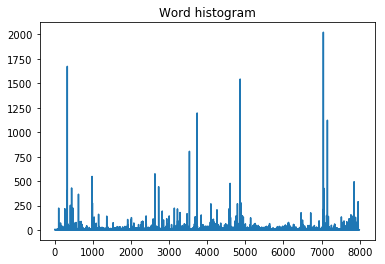

In [96]:
print("Vocabulary size: ", len(vocab))
plt.plot(np.arange(1,len(vocab)+1), dist)
plt.title("Word histogram")
plt.show()

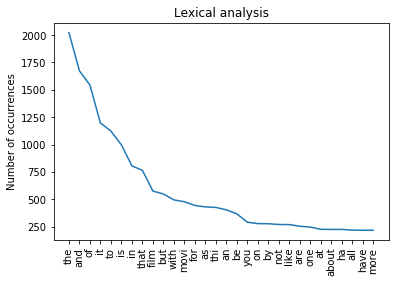

In [97]:
i=0
tabtag = []
x = np.arange(30)
distsorted = sorted(dist, reverse=True) 
distsortedindex = sorted(range(len(dist)), key=lambda k: dist[k],reverse=True)
for count in distsortedindex:
    tabtag.append(vocab[count]) 
    i = i+1

y = distsorted[:30]
my_xticks = tabtag
plt.xticks(x, my_xticks,  rotation='vertical')
plt.ylabel('Number of occurrences')
plt.title('Lexical analysis')
plt.plot(x, y)
plt.show()

Con solo stemming el vocabulario disminuye considerablemente, esto ocurre porque mucho verbos que se encuentran conjugados en el texto original, se transforma a su forma infinitiva (se trunca), haciendo que todas las posibles conjugaciones se representen con un solo valor. Al igual que con lematización, las stopwords aparecen en los primeros lugares del histograma. A continuación veremos cómo se compara el desempeño de stemming con los anteriores.

In [99]:
model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)
test_pred = model.predict_proba(features_test)
spl = random.sample(range(len(test_pred)), 15)
for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print(sentiment, text)

Training Accuracy BernoulliNB: 0.938661
Test Accuracy BernoulliNB: 0.762736
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.77      0.76      0.77      1803
          -       0.76      0.76      0.76      1751

avg / total       0.76      0.76      0.76      3554

[ 0.97818318  0.02181682] the story is also as unoriginal as they come , already having been recycled more times than i'd care to count .

[ 0.75889768  0.24110232] like mike is a slight and uninventive movie : like the exalted michael jordan referred to in the title , many can aspire but none can equal .

[ 0.13183502  0.86816498] one of the most exciting action films to come out of china in recent years .

[ 0.91047403  0.08952597] a boring , formulaic mix of serial killers and stalk'n'slash .

[ 0.89075015  0.10924985] because the intelligence level of the characters must be low , very low , very very low , for the masquerade to work , the movie contains no wi

Stemming logra el mejor resultado, con precisión de $0.76$. Nuevamente, dejar las stopwords en los reviews significó un aumento del desempeño, por lo que un estudio más profundo debe realizarse sobre cúales stopwords son claves para este problema en específico.


### g) SVM

En esta sección, se entrenará una SVM linear para distintos valores de C. Éste parametro controla el *trade-off* entre error de clasificación y tamaño del margen de holgura para la separación óptima por hiperplano. Los valores de C son $[0.01, 0.1, 10, 100, 1000]$, y los conjuntos de entrenamiento siguen el mismo orden que en la pregunta anterior. 

In [100]:
from sklearn.svm import LinearSVC

def do_SVM(x,y,xt,yt):
    Cs = [0.01,0.1,10,100,1000]
    for C in Cs:
        print("C Value: ", C)
        model = LinearSVC(C=C)
        model = model.fit(x, y)
        score_the_model(model,x,y,xt,yt,"SVM")

#### SVM - Lematización + eliminación de stopwords

In [101]:
texts_train = [word_extractor2(text, stop_words=True) for text in train_df.Text]
texts_test = [word_extractor2(text, stop_words=True) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))

In [103]:
do_SVM(features_train,labels_train,features_test,labels_test)

C Value:  0.01
Training Accuracy SVM: 0.885200
Test Accuracy SVM: 0.716296
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.71      0.71      0.71      1751

avg / total       0.72      0.72      0.72      3554

C Value:  0.1
Training Accuracy SVM: 0.989871
Test Accuracy SVM: 0.724740
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.72      0.73      1803
          -       0.72      0.73      0.72      1751

avg / total       0.72      0.72      0.72      3554

C Value:  10
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.704194
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.69      0.70      1803
          -       0.69      0.72      0.70      1751

avg / total       0.70      0.70      0.70      3554

C Value:  100
Train

El mejor resultado ocurre para $C = 0.1$. 

#### SVM - Solo lematización

In [104]:
texts_train = [word_extractor2(text, stop_words=False) for text in train_df.Text]
texts_test = [word_extractor2(text, stop_words=False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))

In [105]:
do_SVM(features_train,labels_train,features_test,labels_test)

C Value:  0.01
Training Accuracy SVM: 0.872257
Test Accuracy SVM: 0.718829
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.71      0.72      0.71      1751

avg / total       0.72      0.72      0.72      3554

C Value:  0.1
Training Accuracy SVM: 0.987901
Test Accuracy SVM: 0.738531
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554

C Value:  10
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.715170
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.69      0.71      1803
          -       0.70      0.74      0.72      1751

avg / total       0.72      0.72      0.72      3554

C Value:  100
Train

Nuevamente, el mejor resultado lo obtiene $C = 0.1$, pero se observa una mejora en la precisión respecto del caso anterior. Entonces, nos encontramos con la misma situación que para Naive Bayes, donde agregar las stopwords mejora el desempeño.

#### SVM - Solo stemming

In [106]:
texts_train = [word_extractor(text, stop_words=False) for text in train_df.Text]
texts_test = [word_extractor(text, stop_words=False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))

In [107]:
do_SVM(features_train,labels_train,features_test,labels_test)

C Value:  0.01
Training Accuracy SVM: 0.868317
Test Accuracy SVM: 0.729806
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.74      0.74      1803
          -       0.73      0.72      0.72      1751

avg / total       0.73      0.73      0.73      3554

C Value:  0.1
Training Accuracy SVM: 0.982836
Test Accuracy SVM: 0.739657
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.74      0.74      0.74      1803
          -       0.73      0.74      0.74      1751

avg / total       0.74      0.74      0.74      3554

C Value:  10
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.718266
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.70      0.72      1803
          -       0.71      0.73      0.72      1751

avg / total       0.72      0.72      0.72      3554

C Value:  100
Train

Finalmente, cuando se hace stemming se obtiene el mejor desempeño para $C = 0.1$, pero esta vez no supera 